In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import root, fsolve

In [2]:
import sys 
path = 'C:/Users/Tomas/PhD_Physics/3rd_Year/Max-Ent_Library'
sys.path.insert(1, path) 

import a_quantum_geometries as gij
import b_spin_ops as su2
import c_maxent_tools as me

In [3]:
params={}

params['size']=6
params['beta']=1.

params['Jx']=1e-0; params['h']=0*.20*params['Jx']
params['Jy'] = .75*params['Jx']; params['Jz']=1.05*params['Jx']; params['chain_type']='XYZ'

Ffactor=np.real(max(np.roots(np.poly1d([1, 0, -(params['Jx']*params['Jy']+params['Jx']*params['Jy']+params['Jy']*params['Jz']), 
                           -2*params['Jx']*params['Jy']*params['Jz']]))))
chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
vLR=4*Ffactor*chi_y
vLR

10.749070088492134

In [4]:
spin_ops=su2.one_body_spin_ops(args=params)

idop=spin_ops['idop']
sx_total=sum(sx for sx in spin_ops['sx'])
sy_total=sum(sx for sx in spin_ops['sy'])
sz_total=sum(sx for sx in spin_ops['sz'])

H=1.*su2.Heisenberg_1D_Hamiltonian(spin_ops=spin_ops, args=params)
#H+=sx_total**2
timespan=np.linspace(0,10*vLR, 200)

## 1. Defining the initial state of the system

We are interested in defining ${\bf K}_0 = - \log \rho_0$ as state with support only on the first site of the lattice 

$$
    {\bf K}_0 = \vec{a} \cdot \vec{\bf S}_0,
$$

thus yielding a state $\rho_0 = |\uparrow\rangle \langle \uparrow| + {\bf I}^{\otimes}$. Furthermore, we are interested in the dynamics of the first three spins.

In [5]:
ptrace_list=[0,1,2]
obs=.5*qutip.tensor(qutip.sigmaz(),qutip.qeye(2),qutip.qeye(2))+.5*qutip.tensor(qutip.qeye(2),qutip.sigmaz(),qutip.qeye(2))+.5*qutip.tensor(qutip.qeye(2),qutip.qeye(2),qutip.sigmaz())


In [6]:
HBB0=[idop, spin_ops['sx'][0], spin_ops['sy'][0], spin_ops['sz'][0]]
phi0=np.array([0., -.25, -.25, -5.])
K0 = gij.Kstate_from_phi_basis(phi=phi0, basis=HBB0)
sigma0=gij.safe_expm_and_normalize(K=K0)
phi0[0]=np.log(sigma0.tr())
K0 = gij.Kstate_from_phi_basis(phi=phi0, basis=HBB0)
sigma0=gij.safe_expm_and_normalize(K=K0)

qutip.expect(spin_ops['sz'], sigma0)

array([4.92160769e-01, 1.42572586e-17, 1.62630326e-19, 5.42101086e-20,
       0.00000000e+00, 0.00000000e+00])

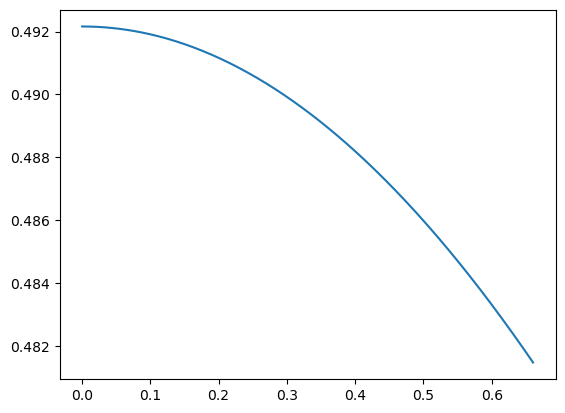

In [29]:
## exact dynamics
timespan=np.linspace(0, 7.1/vLR, 300)
exact_K_at_timet=qutip.mesolve(H=H, rho0=K0, tlist=timespan)
exact_rho_at_timet=[gij.safe_expm_and_normalize(K_at_timeti) for K_at_timeti in exact_K_at_timet.states]
evs_obs_ex=[qutip.expect(rho_at_timeti.ptrace(ptrace_list), obs) for rho_at_timeti in exact_rho_at_timet]
plt.plot(timespan, evs_obs_ex)

In [30]:
## non-actualized dynamics

sp_local=gij.fetch_covar_scalar_product(sigma=sigma0)
HBB_ell_act=gij.build_HierarchicalBasis(generator=H, seed_operator=K0, depth=3)
orth_basis_act=gij.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)
Hij_tensor=gij.Hij_tensor(generator=H, basis=orth_basis_act, sp=sp_local)
phi0_proj_act, K0_proj_act=gij.proj_op(K=K0, basis=orth_basis_act, sp=sp_local)
phi_at_timet_1st=[np.array(linalg.expm(Hij_tensor*(t-0)) @ np.real(phi0_proj_act)) for t in timespan]
K_at_timet_1st=[gij.Kstate_from_phi_basis(phi=-phit, basis=orth_basis_act) for phit in phi_at_timet_1st]
sigma_at_time_1st_ptraced=[gij.safe_expm_and_normalize(K_at_timet_timeti_1st).ptrace([0,1,2]) for K_at_timet_timeti_1st in K_at_timet_1st]
ev_obs_maxent_nonact=[qutip.expect(sigma_at_time_1st_ptraced_timeti, obs) for sigma_at_time_1st_ptraced_timeti in sigma_at_time_1st_ptraced]

In [31]:
local_bound_error=[]; saved_cut_times_index=[0]; ev_obs_maxent_act_low=[qutip.expect(sigma0.ptrace(ptrace_list), obs)]

sp_local=gij.fetch_covar_scalar_product(sigma=sigma0); local_t_value=.0
HBB_ell_act=gij.build_HierarchicalBasis(generator=H, seed_operator=K0, depth=3)
orth_basis_act=gij.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)
Hij_tensor_act=gij.Hij_tensor(generator=H, basis=orth_basis_act, sp=sp_local)
phi0_proj_act, K0_proj_act=gij.proj_op(K=K0, basis=orth_basis_act, sp=sp_local)
phi_at_timet=[phi0_proj_act]; K_at_timet=[K0]; sigma_at_timet=[gij.safe_expm_and_normalize(K0)]

In [32]:
for t in timespan:
    phi_local=np.real(linalg.expm(Hij_tensor_act * (t-local_t_value))@phi0_proj_act)
    K_local=gij.Kstate_from_phi_basis(phi=-phi_local, basis=orth_basis_act)
    sigma_local=gij.safe_expm_and_normalize(K=K_local)

    ev_obs_maxent_act_low.append(qutip.expect(sigma_local.ptrace(ptrace_list),obs))
    local_bound_error.append(gij.m_th_partial_sum(phi=phi_local, m=2)/gij.m_th_partial_sum(phi=phi_local, m=0))

    if local_bound_error[-1] >1e-2: #- local_bound_error[saved_cut_times_index[-1]]>=1e-2:
        print("error", t)
        local_t_value=t; saved_cut_times_index.append(list(timespan).index(t))
        sp_local=gij.fetch_covar_scalar_product(sigma=sigma_local)
        HBB_ell_act=gij.build_HierarchicalBasis(generator=H, seed_operator=K_local, depth=3)
        orth_basis_act=gij.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)
        Hij_tensor_act=gij.Hij_tensor(generator=H, basis=orth_basis_act, sp=sp_local)
        phi0_proj_act=gij.proj_op(K=K_local, basis=orth_basis_act, sp=sp_local)[0]

error 0.0
error 0.002209104527415389
error 0.004418209054830778
error 0.006627313582246167
error 0.008836418109661556
error 0.011045522637076945
error 0.013254627164492334
error 0.015463731691907723
error 0.017672836219323113
error 0.0198819407467385
error 0.02209104527415389
error 0.02430014980156928
error 0.02650925432898467
error 0.028718358856400058
error 0.030927463383815447
error 0.03313656791123083
error 0.035345672438646225
error 0.03755477696606162
error 0.039763881493477
error 0.04197298602089239
error 0.04418209054830778
error 0.046391195075723174
error 0.04860029960313856
error 0.050809404130553945
error 0.05301850865796934
error 0.05522761318538473
error 0.057436717712800116
error 0.0596458222402155
error 0.061854926767630894
error 0.06406403129504629
error 0.06627313582246167
error 0.06848224034987706
error 0.07069134487729245
error 0.07290044940470784
error 0.07510955393212324
error 0.07731865845953861
error 0.079527762986954
error 0.0817368675143694
error 0.083945972041

In [35]:
### Lieb-Robinson scheme:

ells=[ell for ell in range(0, int(timespan[-1]*vLR)+1,1)]
tcuts=[ell/(vLR) for ell in ells]
sliced_times=gij.slice_times(timespan, tcuts)

K_local_last=gij.Kstate_from_phi_basis(phi=phi0, basis=HBB0)
ev_obs_maxent_LR=[qutip.expect(gij.safe_expm_and_normalize(K_local_last).ptrace(ptrace_list), obs)]

for ell in ells:
    print("Starting simulation: d=", ell)
    sp_local=gij.fetch_covar_scalar_product(sigma=gij.safe_expm_and_normalize(K_local_last))
    HBB_ell_act=gij.build_HierarchicalBasis(generator=H, seed_operator=K_local_last, depth=3)
    orth_basis_act=gij.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)
    Hij_tensor_act=gij.Hij_tensor(generator=H, basis=orth_basis_act, sp=sp_local)
    phi0_proj_act=gij.proj_op(K=K_local_last, basis=orth_basis_act, sp=sp_local)[0]
        
    phi_at_timet=[linalg.expm(Hij_tensor_act*(t-sliced_times[ell][0]))@ np.real(phi0_proj_act) for t in sliced_times[ell]]
    K_at_timet=[gij.Kstate_from_phi_basis(phi=-phi_at_timet_ti, basis=orth_basis_act) for phi_at_timet_ti in phi_at_timet]
    sigma_at_timet_local=[gij.safe_expm_and_normalize(K=K_at_timet_ti).ptrace(ptrace_list) for K_at_timet_ti in K_at_timet]

    ev_obs_maxent_LR+=[qutip.expect(sigma_at_timet_local_ti, obs) for sigma_at_timet_local_ti in sigma_at_timet_local]
    K_local_last=K_at_timet[-1]; phi_at_timet=None; K_at_timet=None
    print("Finishing simulation.")

Starting simulation: d= 0
Finishing simulation.
Starting simulation: d= 1
Finishing simulation.
Starting simulation: d= 2
Finishing simulation.
Starting simulation: d= 3
Finishing simulation.
Starting simulation: d= 4
Finishing simulation.
Starting simulation: d= 5
Finishing simulation.
Starting simulation: d= 6
Finishing simulation.
Starting simulation: d= 7
Finishing simulation.


In [36]:
len(ev_obs_maxent_act_low)

301

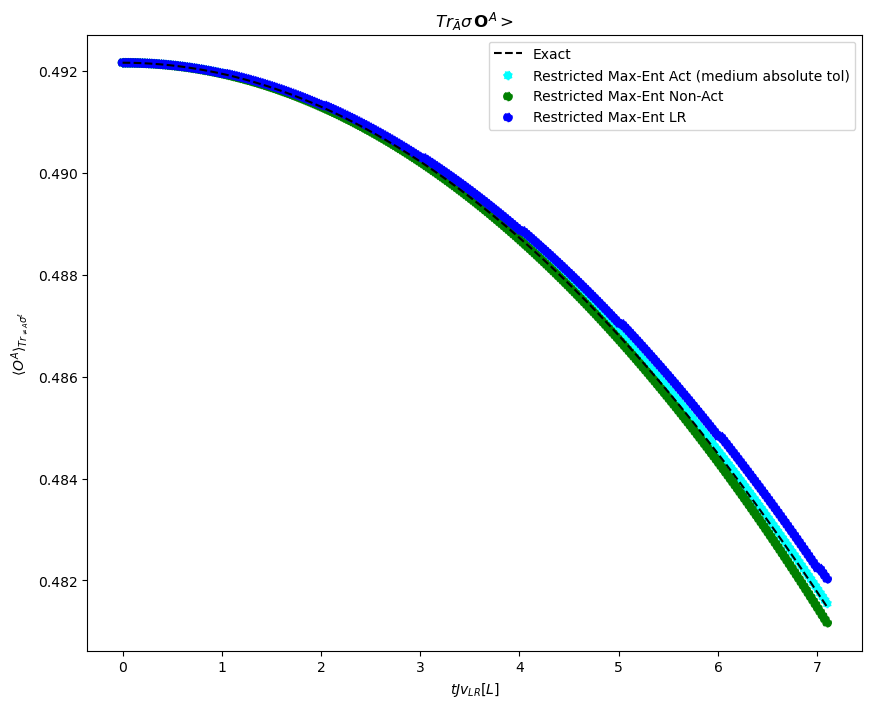

In [37]:
fig0,ax0=plt.subplots(figsize=(10,8))
list_of_colors_1=['r','g', 'b']

plt.plot(timespan*vLR, evs_obs_ex, label='Exact', color="black", linestyle='dashed')
#plt.scatter(timespan*vLR, ev_obs_maxent_act[:-1], label=r'Restricted Max-Ent Act (medium relative tol)', color='blue', linestyle='dotted')
plt.scatter(timespan*vLR, ev_obs_maxent_act_low[:-1], label=r'Restricted Max-Ent Act (medium absolute tol)', color='cyan', linestyle='dotted')
plt.scatter(timespan*vLR, ev_obs_maxent_nonact, label=r'Restricted Max-Ent Non-Act', color='green', linestyle='dashdot')
plt.scatter(timespan*vLR, ev_obs_maxent_LR[:-1], label=r'Restricted Max-Ent LR', color='blue', linestyle='dashdot')

ax0.legend(loc=0)
plt.xlabel(r'$tJ v_{LR} [L]$')
plt.ylabel(r"$\langle O^{A} \rangle_{Tr_{\neq A}\sigma^\ell}$")
plt.title(r'$Tr_{\bar A} \sigma \, {\bf O}^{A}>$')
plt.show()